In [1]:
import os
import random
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
CVPR = '/kaggle/input/cifar-10-images-master/CIFAR-10-images-master/train'
CATEGORIES = []
for c in os.listdir(CVPR):
    CATEGORIES.append(c)
print(CATEGORIES)

['airplane', 'horse', 'truck', 'automobile', 'ship', 'dog', 'bird', 'frog', 'cat', 'deer']


In [3]:
TRAIN_DATA = []
for c in CATEGORIES:
    path = os.path.join(CVPR,c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        img_arr = cv2.imread(os.path.join(path,img))
        TRAIN_DATA.append([img_arr, class_num])
print(len(TRAIN_DATA))

100%|██████████| 5000/5000 [00:21<00:00, 234.47it/s]

50000


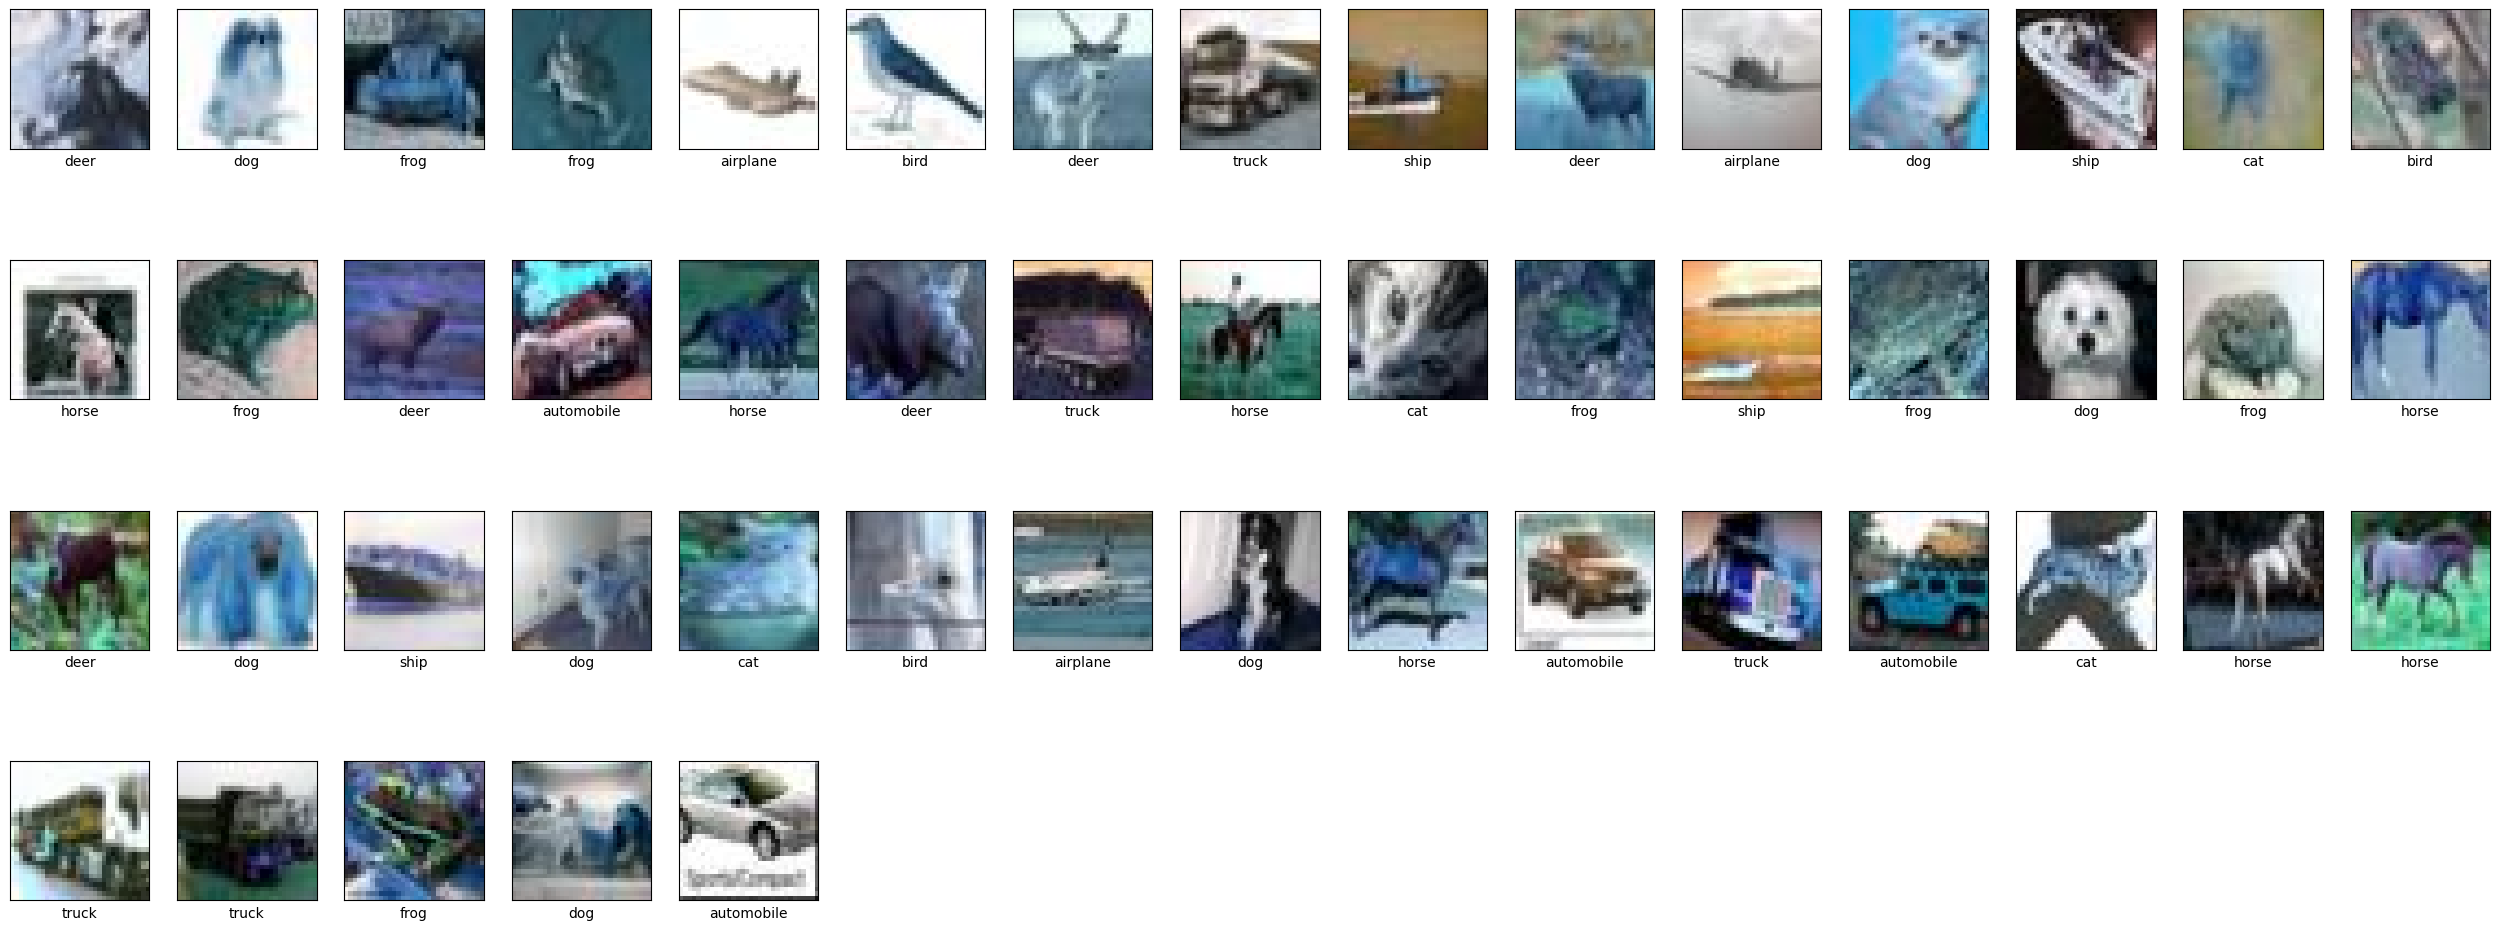

In [4]:
random.shuffle(TRAIN_DATA)
plt.figure(figsize=(32,32))

for i in range(50):
    plt.subplot(10,15,i+1)
    plt.imshow(TRAIN_DATA[i][0])
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i==50:
        break
plt.show()

In [5]:
f0 = TRAIN_DATA[0:1000]
f1 = TRAIN_DATA[1000:2000]
f2 = TRAIN_DATA[2000:3000]
f3 = TRAIN_DATA[3000:4000]
f4 = TRAIN_DATA[4000:5000]

In [6]:
def by_l1_dist(list):
    return list[2]["l1"]

def by_l2_dist(list):
    return list[2]["l2"]

In [7]:
top_filter = 30
def distance_calc(train_fold, valid_fold):
    l1_result = []
    l2_result = []
    for valid in tqdm(valid_fold): 
        temp_dist_list = []
        for train in train_fold: 
            l1_dist = np.sum(np.abs(valid[0]-train[0]))
            l2_dist = np.sqrt(np.sum(valid[0]-train[0]**2))
            temp_dist_list.append([valid[1],  train[1], {"l1": l1_dist, "l2": l2_dist}])
        temp_dist_list.sort(key=by_l1_dist)
        l1_result.append(temp_dist_list[:top_filter])
        temp_dist_list.sort(key=by_l2_dist)
        l2_result.append(temp_dist_list[:top_filter])
    return [l1_result, l2_result]

In [8]:
k_range = 5
def cal_accuracy(dist_result, dist_term):
    k_accuracies = []  
    for k in range(1, k_range+1):
        img_accuracy = 0
        for valid_img in dist_result:
            nn = valid_img[:k]
            same_class = [n for n in nn if n[0] == n[1]]
            same_class_len = len(same_class)
            if k % 2 != 0:                      
                if ((k-1) / 2) < same_class_len:  
                    img_accuracy += 1
            else:                                  
                diff_class = [n for n in nn if n[0] != n[1]]
                if same_class_len > len(diff_class):    
                    img_accuracy += 1
                elif same_class_len == len(diff_class): # tie
                    same_class_dist = sum([n[2][dist_term] for n in same_class])
                    diff_class_dist = sum([n[2][dist_term] for n in diff_class])
                    if same_class_dist > diff_class_dist:   
                        img_accuracy += 1
        k_accuracies.append(img_accuracy/len(dist_result))
    return k_accuracies

In [9]:
dist_by_fold = []
import math 
for i in range(5):
    if i==0:
        train = f1+f2+f3+f4
        validation = f0    
    elif i==1:
        train = f0+f2+f3+f4
        validation = f1
    elif i==2:
        train = f1+f0+f3+f4
        validation = f2
    elif i==3:
        train = f1+f2+f0+f4
        validation = f3
    elif i==4:
        train = f1+f2+f3+f0
        validation = f4
    
    dist_by_fold.append(distance_calc(train, validation))  

100%|██████████| 1000/1000 [02:39<00:00,  6.29it/s]


In [10]:
accuracies = []

for result in dist_by_fold:
    l1_accuracy = cal_accuracy(result[0], "l1")
    l2_accuracy = cal_accuracy(result[1], "l2")
    accuracies.append([l1_accuracy, l2_accuracy])

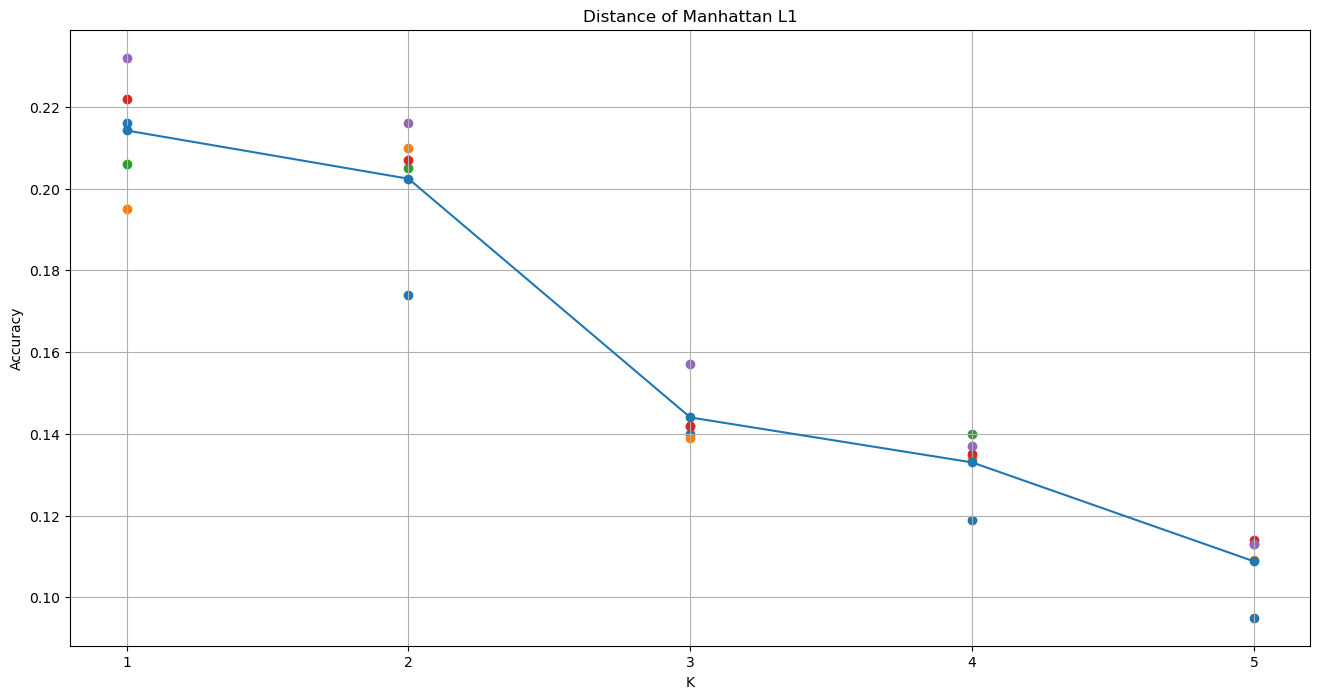

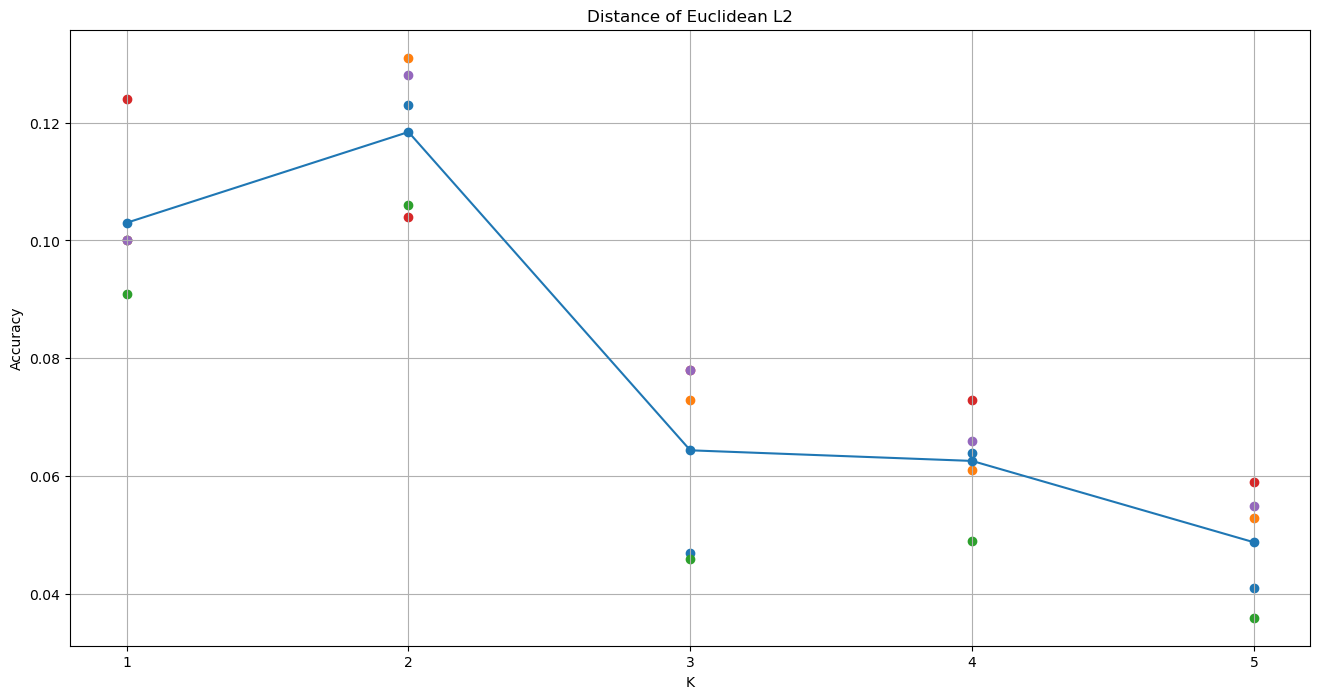

In [12]:
x_list = list(range(1, k_range+1))
plt.figure(figsize=(16, 8))

for fold in accuracies:
  y_list = fold[0]
  plt.scatter(x_list, y_list)
arr = []
for i in range(k_range):
  arr.append([fold[0][i] for fold in accuracies])
trend = [np.mean(a) for a in arr]
plt.errorbar(x_list, trend,fmt='-o')
plt.title('Distance of Manhattan L1')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

x_list = list(range(1, k_range+1))
plt.figure(figsize=(16, 8))

for fold in accuracies:
  y_list = fold[1]
  plt.scatter(x_list, y_list)
arr = []
for i in range(k_range):
  arr.append([fold[1][i] for fold in accuracies])
trend = [np.mean(a) for a in arr]
plt.errorbar(x_list, trend,fmt='-o')
plt.title('Distance of Euclidean L2')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()